# Analysis of drifting grating stimulus calibration, incl. tuning curve shape estimation

Requires:

- Campaign with baseline scan, w/o opto stim, at 4 contrast levels at least
- "single_cell_psths" campaign analysis results
- "psth_peak_stats" campaign analysis results for each pattern (contrast)
- Average contrast tuning results (currently computed with bbp-workflow_sim-campaign-analysis.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from bluepy import Cell, Synapse, Circuit, Simulation
import os
import pickle
from scipy.ndimage.filters import gaussian_filter
# from helper_functions import load_sim_results, get_activity, plot_PSTH #, get_single_cell_psths, detect_rate_peaks
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', message='invalid value encountered in double_scalars')
warnings.filterwarnings('ignore', message='Mean of empty slice')

In [16]:
sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/visual_contrast/3244ae1f-e48a-49f5-86c0-f9c92fb4b076/analyses/simulations.pkl' # Baseline scan incl. tuning with James' Ca 1.05 conductance settings
sims = pd.read_pickle(sims_file)

res_path_base = os.path.split(sims_file)[0]
res_path = os.path.join(res_path_base, 'output')
save_path = os.path.join(res_path_base, 'visual_contrast_analysis')
if not os.path.exists(save_path):
    os.makedirs(save_path)

## Load results from all simulations

- Single-cell PSTH data
- Peak responses to drifting gratings (at different contrast levels)
- Tuning curve fit parameters

In [33]:
# Load PSTH results ["single_cell_psths" and "psth_peak_stats" launched with bbp-workflow, "contrast_tuning" from bbp-workflow_sim-campaign-analysis.ipynb]
psth_res_name = 'single_cell_psths'
peak_res_name = 'psth_peak_stats'
tuning_res_name = 'contrast_tuning'
name_suffix = '__hex0_EXC'

psth_data = {}
peak_data = {}
tuning_data = {}
contrast_levels = None
cond_names = sims.index.names
for sim_idx, (cond, cfg_path) in enumerate(sims.iteritems()):
    cond_dict = dict(zip(cond_names, cond))
    sim_id = os.path.split(os.path.split(cfg_path)[0])[-1] # Subfolder name (i.e., 000, 001, ...)
    sim_spec = '__'.join([f'{k}_{v}' for k, v in cond_dict.items()]) # Sim conditions (e.g., sparsity_1.0__rate_bk_0.2__rate_max_10.0)

    # PSTH data
    res_file = os.path.join(res_path, psth_res_name, f'{psth_res_name}{name_suffix}__SIM{sim_id}__{sim_spec}.pickle')
    assert os.path.exists(res_file), f'ERROR: "{res_file}" not found!'
    with open(res_file, 'rb') as f:
        res = pickle.load(f)
    psth_data[sim_idx] = res

    if contrast_levels is None:
        contrast_levels = res['stim_cfg']['cfg']['contrast_levels']
    else:
        assert np.array_equal(contrast_levels, res['stim_cfg']['cfg']['contrast_levels'])

    # Peak data
    res_list = []
    for pat in range(len(contrast_levels)):
        res_file = os.path.join(res_path, peak_res_name, f'{peak_res_name}{name_suffix}__SIM{sim_id}__{sim_spec}__PAT{pat}.pickle')
        assert os.path.exists(res_file), f'ERROR: "{res_file}" not found!'
        with open(res_file, 'rb') as f:
            res = pickle.load(f)
        res_list.append(res)
    peak_data[sim_idx] = res_list

    # Tuning data
    res_file = os.path.join(res_path, tuning_res_name, f'{tuning_res_name}{name_suffix}__SIM{sim_id}__{sim_spec}.pickle')
    assert os.path.exists(res_file), f'ERROR: "{res_file}" not found!'
    with open(res_file, 'rb') as f:
        res = pickle.load(f)
    assert np.array_equal(contrast_levels, res['c_data'])
    tuning_data[sim_idx] = res


### Plot peak statistics overview

- Mean first/second peak rates at different contrasts
- Mean first vs. second peak difference at different contrasts

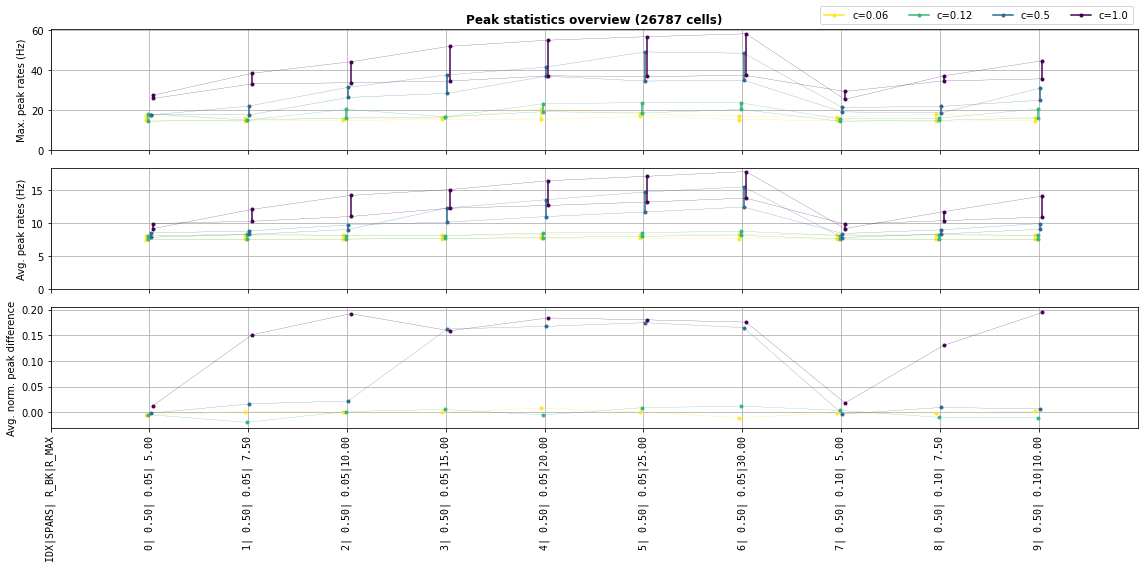

In [252]:
# Plot peak statistics overview
sim_ids = list(peak_data.keys())
# c_colors = plt.cm.tab10(np.linspace(0, 1, 10)) # Contrast colors
# assert(len(contrast_levels) <= c_colors.shape[0])
c_colors = plt.cm.viridis_r(np.linspace(0, 1, len(contrast_levels)))
c_offset = 0.025

plt.figure(figsize=(16, 8))
plt.subplot(3, 1, 1)
for cidx, c in enumerate(contrast_levels):
    peak_rates = np.array([[np.nanmax(peak_data[sidx][cidx]['r1']), np.nanmax(peak_data[sidx][cidx]['r2'])] for sidx in sim_ids])
    for sidx in range(len(sim_ids)):
        plt.plot([sidx + c_offset * (cidx - 0.5 * (len(contrast_levels) - 1))] * 2, [peak_rates[sidx, 0], peak_rates[sidx, 1]], '.-', color=c_colors[cidx, :], clip_on=False, label=f'c={c}' if sidx == 0 else None)
#     plt.plot(np.arange(len(sim_ids)), peak_rates[:, 1], '.-', color=c_colors[cidx, :], markersize=10, clip_on=False, label='Second peak')
    plt.plot(np.arange(len(sim_ids)) + c_offset * (cidx - 0.5 * (len(contrast_levels) - 1)), peak_rates[:, 0], '-', color=c_colors[cidx, :], lw=0.2, clip_on=False)
    plt.plot(np.arange(len(sim_ids)) + c_offset * (cidx - 0.5 * (len(contrast_levels) - 1)), peak_rates[:, 1], '-', color=c_colors[cidx, :], lw=0.2, clip_on=False)
plt.xlim([-1, len(sim_ids)])
xticks = [min(plt.xlim())] + np.arange(len(sim_ids)).tolist()
plt.xticks(xticks, [])
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Max. peak rates (Hz)')
plt.grid()
plt.legend(ncol=len(contrast_levels), loc='lower right', bbox_to_anchor=[1.0, 1.0])
plt.title(f'Peak statistics overview ({len(peak_data[sim_ids[0]][0]["peak_diff"])} cells)', fontweight='bold')

plt.subplot(3, 1, 2)
for cidx, c in enumerate(contrast_levels):
    peak_rates = np.array([[np.nanmean(peak_data[sidx][cidx]['r1']), np.nanmean(peak_data[sidx][cidx]['r2'])] for sidx in sim_ids])
    for sidx in range(len(sim_ids)):
        plt.plot([sidx + c_offset * (cidx - 0.5 * (len(contrast_levels) - 1))] * 2, [peak_rates[sidx, 0], peak_rates[sidx, 1]], '.-', color=c_colors[cidx, :], clip_on=False, label=f'c={c}' if sidx == 0 else None)
#     plt.plot(np.arange(len(sim_ids)), peak_rates[:, 1], '.-', color=c_colors[cidx, :], markersize=10, clip_on=False, label='Second peak')
    plt.plot(np.arange(len(sim_ids)) + c_offset * (cidx - 0.5 * (len(contrast_levels) - 1)), peak_rates[:, 0], '-', color=c_colors[cidx, :], lw=0.2, clip_on=False)
    plt.plot(np.arange(len(sim_ids)) + c_offset * (cidx - 0.5 * (len(contrast_levels) - 1)), peak_rates[:, 1], '-', color=c_colors[cidx, :], lw=0.2, clip_on=False)
plt.xlim([-1, len(sim_ids)])
xticks = [min(plt.xlim())] + np.arange(len(sim_ids)).tolist()
plt.xticks(xticks, [])
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Avg. peak rates (Hz)')
plt.grid()

plt.subplot(3, 1, 3)
for cidx, c in enumerate(contrast_levels):
    peak_diffs = np.array([np.nanmean(peak_data[sidx][cidx]['peak_diff']) for sidx in sim_ids])
    plt.plot(np.arange(len(sim_ids)) + c_offset * (cidx - 0.5 * (len(contrast_levels) - 1)), peak_diffs, '.-', color=c_colors[cidx, :], lw=0.2)

plt.xlim([-1, len(sim_ids)])
head_label = ['|'.join(['IDX'] + [f'{n.upper().replace("RATE", "R")[:5]:>5}' for n in sims.iloc[sim_ids].index.names[:3]])]
idx_labels = ['|'.join([f'{sim_ids[idx]:3}'] + [f'{i:5.2f}' for i in val[:3]]) for idx, val in enumerate(sims.iloc[sim_ids].index)]
plt.xticks(xticks, head_label + idx_labels, rotation=90, font='monospace')
plt.ylabel('Avg. norm. peak difference')
plt.grid()

plt.tight_layout()
# plt.savefig(os.path.join(save_path, f'peak_stat_overview.png'), dpi=300)
plt.show()

### Plot tuning curve fit parameters

- m, n, Rmax, c50 curve fitting parameters of population mean contrast tuning
- Computed within first/secon half or full tuning interval

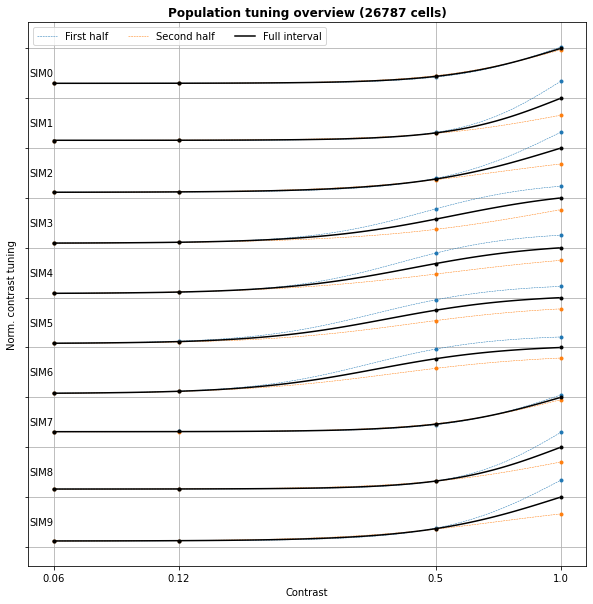

In [219]:
# Plot tuning curve overview
R = lambda c, m, n, Rmax, c50: (Rmax * c**n) / (c**n + c50**n) + m # Sigmoidal response function R(c) [Shapiro et al. 2021]
c_data = contrast_levels
c_fit = np.arange(min(c_data), max(c_data), 0.01)
y_offsets = -np.arange(0, len(sim_ids) + 1) * 1.0
plt.figure(figsize=(10, 10))
for sidx, y_off in zip(sim_ids, y_offsets[1:]):
    r_norm = tuning_data[sidx]['r_data'][2][-1]

    # First half of tuning interval
    r_data = tuning_data[sidx]['r_data'][0]
    p_opt = tuning_data[sidx]['p_opt'][0]
    plt.plot(c_fit, y_off + R(c_fit, **p_opt) / r_norm, '--', color='tab:blue', lw=0.5, label='First half' if sidx==sim_ids[0] else None)
    plt.plot(c_data, y_off + r_data / r_norm, '.', color='tab:blue')

    # Second half of tuning interval
    r_data = tuning_data[sidx]['r_data'][1]
    p_opt = tuning_data[sidx]['p_opt'][1]
    plt.plot(c_fit, y_off + R(c_fit, **p_opt) / r_norm, '--', color='tab:orange', lw=0.5, label='Second half' if sidx==sim_ids[0] else None)
    plt.plot(c_data, y_off + r_data / r_norm, '.', color='tab:orange')

    # Full tuning interval
    r_data = tuning_data[sidx]['r_data'][2]
    p_opt = tuning_data[sidx]['p_opt'][2]
    plt.plot(c_fit, y_off + R(c_fit, **p_opt) / r_norm, '-', color='k', label='Full interval' if sidx==sim_ids[0] else None)
    plt.plot(c_data, y_off + r_data / r_norm, '.', color='k')

    plt.text(min(c_data), y_off + 0.5, f'SIM{sidx}', ha='right', va='center')

plt.gca().set_xscale('log')
plt.xticks(c_data, labels=c_data)
plt.gca().minorticks_off()
# plt.yticks(y_offsets, labels=[''] + [f'SIM{sidx}' for sidx in sim_ids])
plt.yticks(y_offsets, labels=[])
plt.xlabel('Contrast')
plt.ylabel('Norm. contrast tuning')
plt.grid()
plt.legend(ncol=3, loc='upper left')
plt.title(f'Population tuning overview ({len(peak_data[sim_ids[0]][0]["peak_diff"])} cells)', fontweight='bold')
# plt.savefig(os.path.join(save_path, f'tuning_overview.png'), dpi=300)
plt.show()


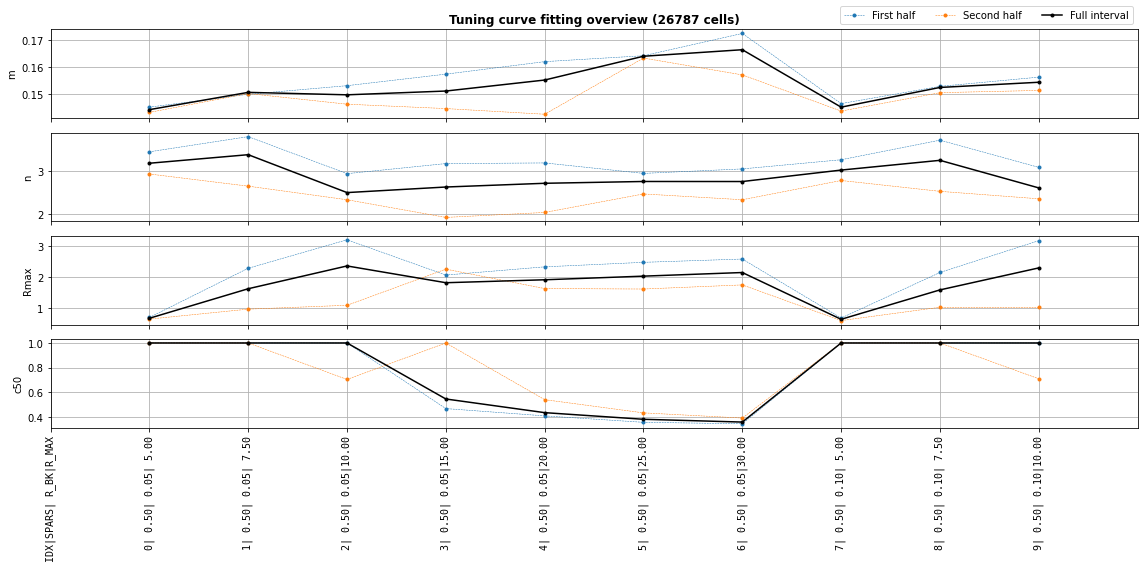

In [247]:
# Plot tuning curve fit parameters
fit_params = ['m', 'n', 'Rmax', 'c50']
plt.figure(figsize=(16, 8))
for pidx, p in enumerate(fit_params):
    plt.subplot(len(fit_params), 1, pidx + 1)
    pval = np.array([tuning_data[sidx]['p_opt'][0][p] for sidx in sim_ids])
    plt.plot(np.arange(len(sim_ids)), pval, '.--', color='tab:blue', lw=0.5, clip_on=False, label='First half')

    pval = np.array([tuning_data[sidx]['p_opt'][1][p] for sidx in sim_ids])
    plt.plot(np.arange(len(sim_ids)), pval, '.--', color='tab:orange', lw=0.5, clip_on=False, label='Second half')

    pval = np.array([tuning_data[sidx]['p_opt'][2][p] for sidx in sim_ids])
    plt.plot(np.arange(len(sim_ids)), pval, '.-', color='k', clip_on=False, label='Full interval')

    plt.xlim([-1, len(sim_ids)])
    xticks = [min(plt.xlim())] + np.arange(len(sim_ids)).tolist()
    plt.xticks(xticks, [])
    plt.ylabel(p)
    plt.grid()
    if pidx == 0:
        plt.legend(ncol=3, loc='lower right', bbox_to_anchor=[1.0, 1.0])
        plt.title(f'Tuning curve fitting overview ({len(peak_data[sim_ids[0]][0]["peak_diff"])} cells)', fontweight='bold')

plt.xlim([-1, len(sim_ids)])
head_label = ['|'.join(['IDX'] + [f'{n.upper().replace("RATE", "R")[:5]:>5}' for n in sims.iloc[sim_ids].index.names[:3]])]
idx_labels = ['|'.join([f'{sim_ids[idx]:3}'] + [f'{i:5.2f}' for i in val[:3]]) for idx, val in enumerate(sims.iloc[sim_ids].index)]
plt.xticks(xticks, head_label + idx_labels, rotation=90, font='monospace')
plt.tight_layout()
# plt.savefig(os.path.join(save_path, f'curve_fit_overview.png'), dpi=300)
plt.show()